In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# import packages
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
tf.test.is_gpu_available()

False

In [2]:
# define path to training data and count number of images
data_dir1 = '../input/state-farm-distracted-driver-detection/imgs/train'
data_dir = pathlib.Path(data_dir1)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

22424


In [3]:
batch_size = 64
img_width = 200
img_height = int(img_width/640*480)
print(img_height)
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)
# train_ds.class_names = ['safe_drive', 'text_r', 'phone_r', 'text_l', 'phone_l', 'radio', 'drink', 'reach_bhd', 'hair_mkup', 'talk_passenger']
# val_ds.class_names = ['safe_drive', 'text_r', 'phone_r', 'text_l', 'phone_l', 'radio', 'drink', 'reach_bhd', 'hair_mkup', 'talk_passenger']
class_names = train_ds.class_names
print(class_names)


150
Found 22424 files belonging to 10 classes.
Using 17940 files for training.
Found 22424 files belonging to 10 classes.
Using 4484 files for validation.
['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


(64, 150, 200, 3)
(64,)


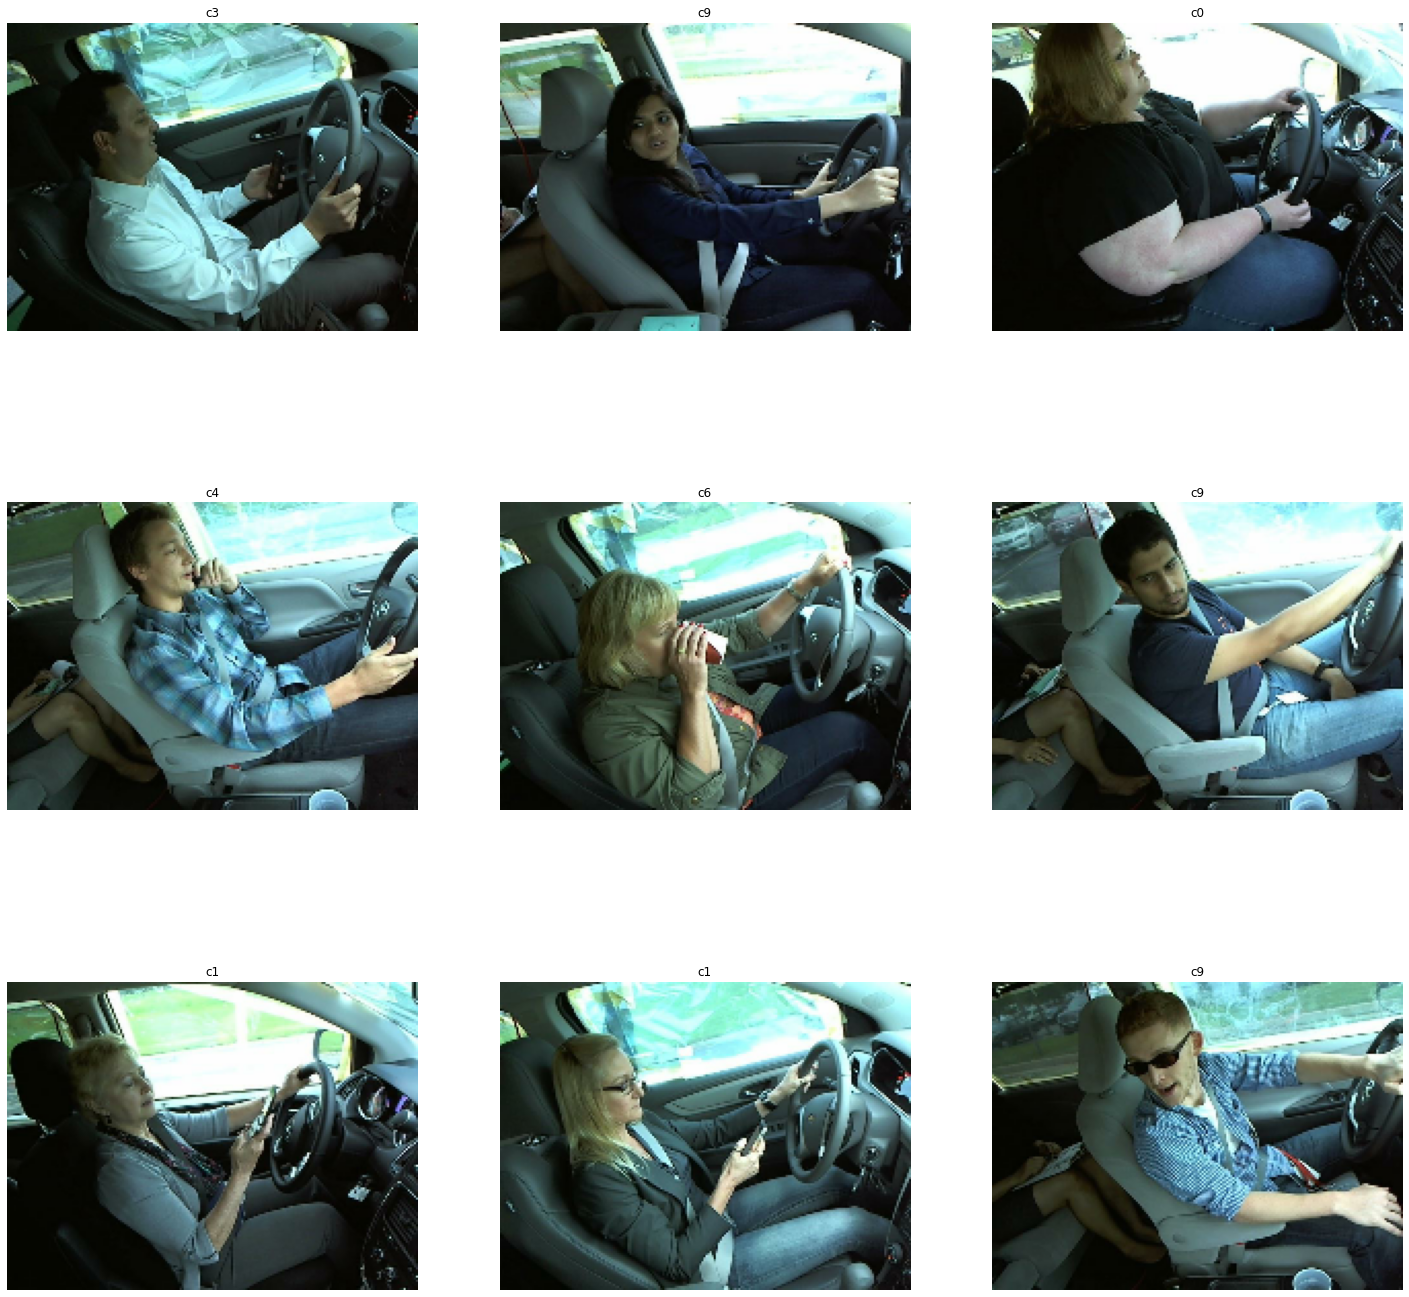

In [4]:
plt.figure(figsize=(25, 25))
for images, labels in train_ds.take(3):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Define data augmentation layers
==

In [5]:
img_augmentation = Sequential(
    [
        layers.RandomTranslation(height_factor=0.1, width_factor=(0,0.1), input_shape=(img_height, img_width, 3)),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomZoom(-0.2, 0.1),
        layers.RandomContrast(factor=(0.2,0)),
    ],
    name="img_augmentation",
)

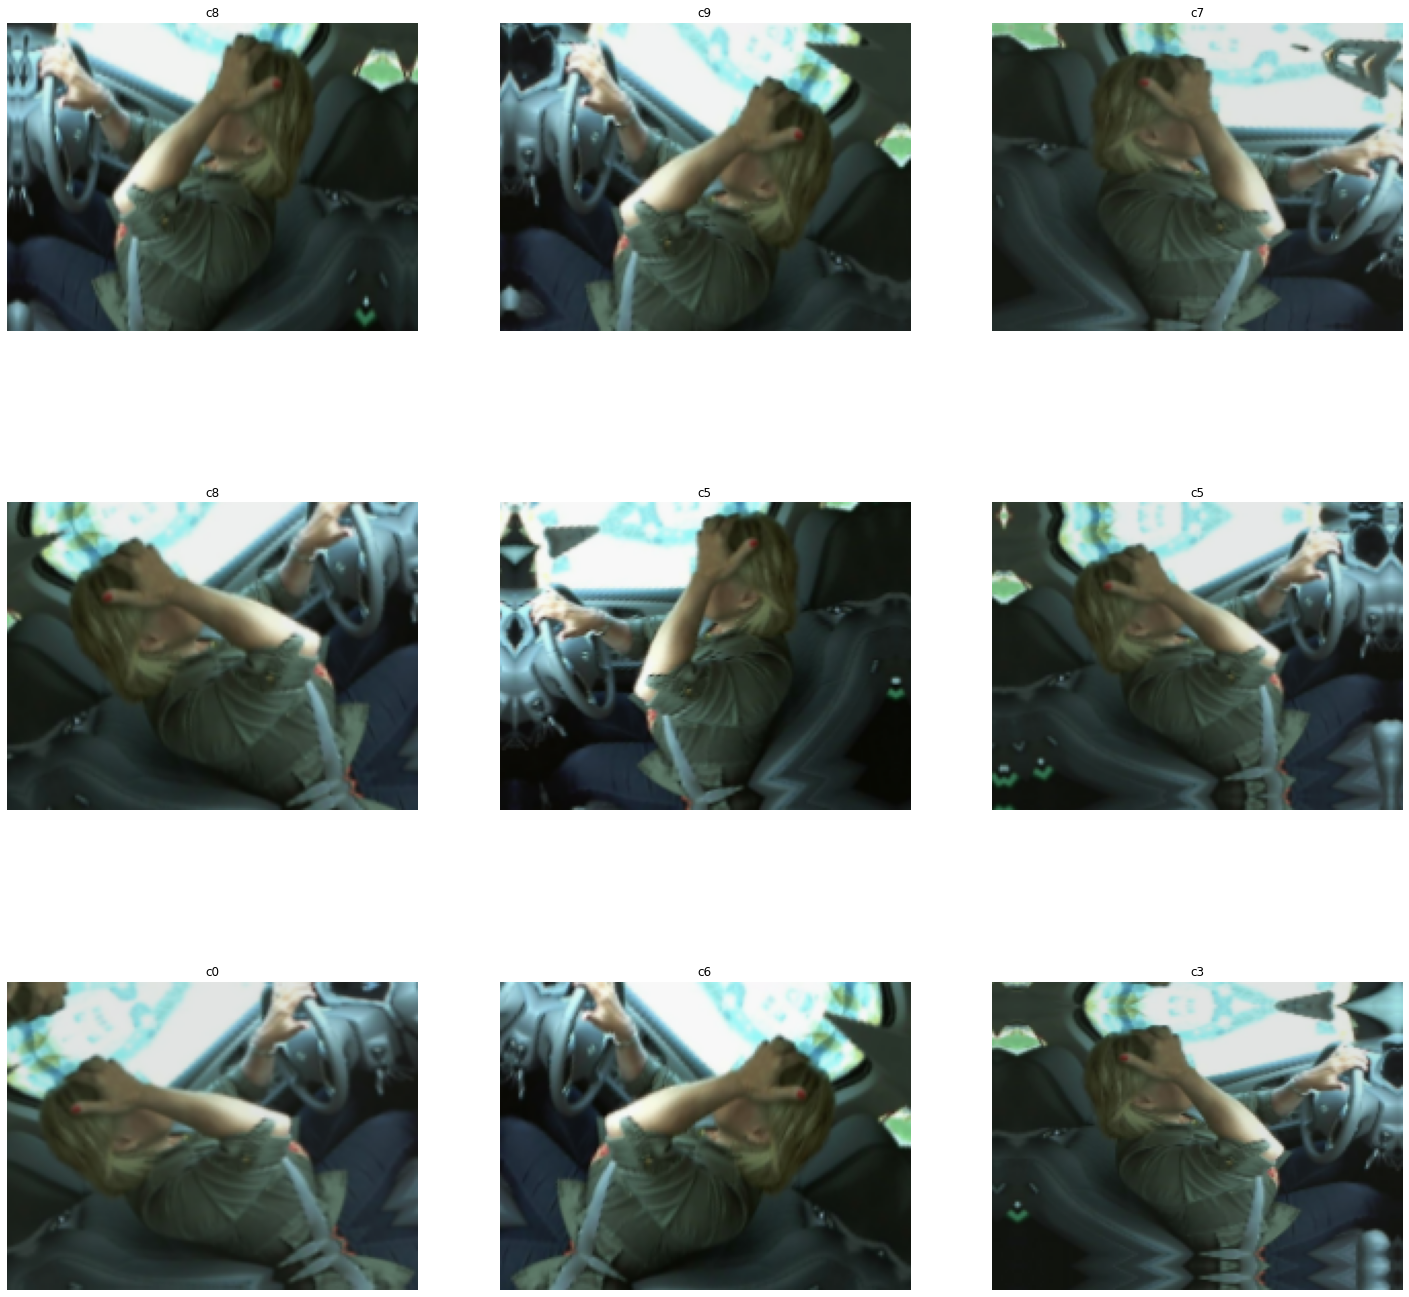

In [6]:
# view augmented images
plt.figure(figsize=(25, 25))
for image, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image[0], axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Speed up data loading with cache and prefetch
==

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Build simple CNN model
=

In [8]:
num_classes = len(class_names)

model = Sequential([

    img_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(16, 3, padding='same'),
#     layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, padding='same'),
#     layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, padding='same'),
#     layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_augmentation (Sequential (None, 150, 200, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 200, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 150, 200, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 100, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 100, 32)       4640      
_________________________________________________________________
activation_1 (Activation)    (None, 75, 100, 32)       0

In [9]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 [==============================] - 211s 696ms/step - loss: 2.1234 - sparse_categorical_accuracy: 0.2144 - val_loss: 1.7072 - val_sparse_categorical_accuracy: 0.3693
Epoch 2/30
281/281 [==============================] - 177s 630ms/step - loss: 1.5144 - sparse_categorical_accuracy: 0.4588 - val_loss: 1.3273 - val_sparse_categorical_accuracy: 0.5604
Epoch 3/30
281/281 [==============================] - 177s 631ms/step - loss: 1.1255 - sparse_categorical_accuracy: 0.6037 - val_loss: 1.3877 - val_sparse_categorical_accuracy: 0.5934
Epoch 4/30
281/281 [==============================] - 178s 634ms/step - loss: 0.9037 - sparse_categorical_accuracy: 0.6909 - val_loss: 0.8544 - val_sparse_categorical_accuracy: 0.7252
Epoch 5/30
281/281 [==============================] - 178s 633ms/step - loss: 0.7285 - sparse_categorical_accuracy: 0.7539 - val_loss: 0.8647 - val_sparse_categorical_accuracy: 0.7393
Epoch 6/30
281/281 [==============================] - 178s 631ms/step - loss: 0.

In [10]:
model.evaluate(x=val_ds)
model.evaluate(x=train_ds)

281/281 [==============================] - 28s 101ms/step - loss: 0.3290 - sparse_categorical_accuracy: 0.9028


[0.3289593458175659, 0.9028428196907043]

Analyse results
=

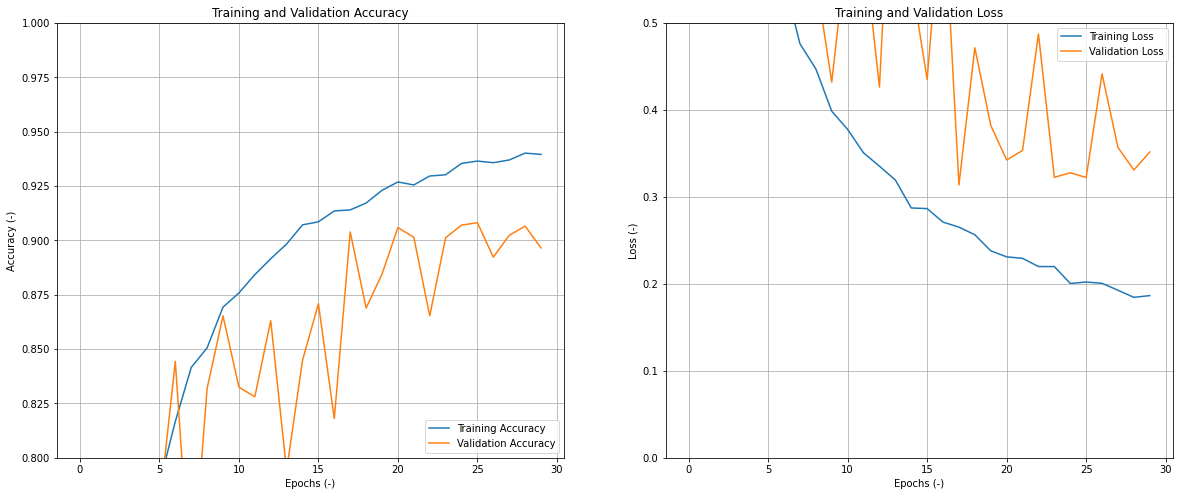

In [11]:
# plot accuracy and loss history
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim((0.8,1))
plt.grid(True)
plt.xlabel("Epochs (-)")
plt.ylabel("Accuracy (-)")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim((0.0,0.5))
plt.grid(True)
plt.xlabel("Epochs (-)")
plt.ylabel("Loss (-)")
plt.title('Training and Validation Loss')
plt.show()

In [12]:
# Check log loss equation
p = model.predict(val_ds)
labels = np.concatenate([y for x, y in val_ds], axis=0)
y = tf.one_hot(labels, 10)
p = p / np.sum(p, axis=1, keepdims=True)
p[p > 1-1E-15] = 1-1E-15
p[p < 1e-15] = 1e-15

log_loss = - np.sum(y * np.log(p))/p.shape[0]
print(log_loss)


0.35159794503721564


tf.Tensor(
[[365   0   7  11   1   1   0   1   4  65]
 [  7 431   5  12   0   0   2   0   5   5]
 [  1   0 417   9   2   0   0   2  17   2]
 [  6   4   0 425  19   0   0   0   0   2]
 [  6   0   1  14 436   0   0   0   1   6]
 [  7   0   2   1   3 426   0   0   0  10]
 [  0   8  17   5   6   1 415   4   8   5]
 [  2   1   6   0   0   0   1 409   5   1]
 [  8   6  29   3  24   2  17   5 284  14]
 [ 24   0   7   1   1   3   1   7   1 412]], shape=(10, 10), dtype=int32)


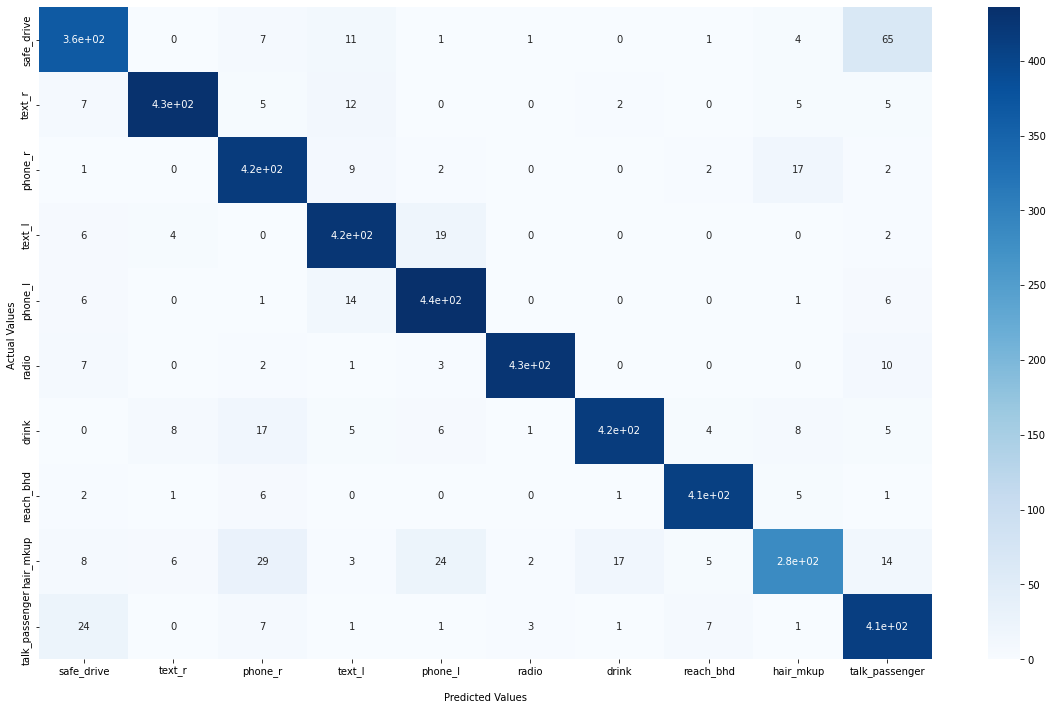

In [13]:
# plot confusion matrix
predictions = np.argmax(model.predict(val_ds), axis=1)
labels = np.concatenate([y for x, y in val_ds], axis=0)
confusMatrx = tf.math.confusion_matrix(labels, predictions)
print(confusMatrx)

import seaborn as sns
plt.figure(figsize=(20, 12))
# ax = sns.heatmap(10*confusMatrx/np.sum(confusMatrx), annot=True, cmap='Blues')
ax = sns.heatmap(confusMatrx, annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['safe_drive', 'text_r', 'phone_r', 'text_l', 'phone_l', 'radio', 'drink', 'reach_bhd', 'hair_mkup', 'talk_passenger'])
ax.yaxis.set_ticklabels(['safe_drive', 'text_r', 'phone_r', 'text_l', 'phone_l', 'radio', 'drink', 'reach_bhd', 'hair_mkup', 'talk_passenger'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [16]:
#classification report
from sklearn import metrics
class_labels = list(['safe_drive', 'text_r', 'phone_r', 'text_l', 'phone_l', 'radio', 'drink', 'reach_bhd', 'hair_mkup', 'talk_passenger'])
report = metrics.classification_report(labels, predictions, target_names=class_labels, zero_division=1)
print(report)

                precision    recall  f1-score   support

    safe_drive       0.86      0.80      0.83       455
        text_r       0.96      0.92      0.94       467
       phone_r       0.85      0.93      0.89       450
        text_l       0.88      0.93      0.91       456
       phone_l       0.89      0.94      0.91       464
         radio       0.98      0.95      0.97       449
         drink       0.95      0.88      0.92       469
     reach_bhd       0.96      0.96      0.96       425
     hair_mkup       0.87      0.72      0.79       392
talk_passenger       0.79      0.90      0.84       457

      accuracy                           0.90      4484
     macro avg       0.90      0.89      0.90      4484
  weighted avg       0.90      0.90      0.90      4484



In [17]:
# save model
model.save('simple_CNN_v1.h5')